In [1]:
import bagpipes as pipes
import numpy as np
from astropy.table import Table
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
from scipy.interpolate import interp1d
from scipy.integrate import simps

from astropy.cosmology import WMAP9 as cosmo
import itertools as it

c_A = 2.9979e18 # speed of light in Angstrom/s
np.seterr(divide='ignore')
directory = './'

In [2]:
def my_plot_style():
    params = {'legend.fontsize': 15,
    'axes.labelsize': 15,
    'axes.titlesize':15,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'xtick.major.size':5,
    'xtick.minor.size':2.5,
    'ytick.major.size':5,
    'ytick.minor.size':2.5,
    'figure.facecolor':'w',
    #'lines.linewidth' : 1.5,
    'xtick.major.width':2.5,
    'ytick.major.width':2.5,
    'xtick.minor.width':2.5,
    'ytick.minor.width':2.5,
    'axes.linewidth':1.5,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'ytick.labelleft':True,
    'text.usetex' : False,
    'font.family': 'sans-serif'}
    plt.rcParams.update(params)
my_plot_style()

In [3]:
###### Functions to generate spectra and filters ######
def getfilter(filtername):
    filter = Table.read('filters/{}.dat'.format(filtername), format='ascii')
    filter.rename_column('col1', 'wave')
    filter.rename_column('col2', 'transmission')
    filter['nu'] = c_A/filter['wave']
    return filter

def bagpipes_burst(age, massformed, metallicity, Av, redshift,
                   lambda_min=1000, lambda_max=10000, delta_lambda=10):

  # The first stellar population we will explore is just a simple one.
  # This means that the star formation history is a delta function.
    burst = {}                           # Delta function burst
    burst["age"] = age
    burst["massformed"] = massformed   # Log_10 total stellar mass formed: M_Solar
    burst["metallicity"] = metallicity  # Metallicity: Z_sol = 0.02

    dust = {}                         # Dust component
    dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
    dust["Av"] = Av                  # magnitudes


    model_components = {}                   # The model components dictionary
    model_components["redshift"] = redshift      # Observed redshift  
    model_components["burst"] = burst   
    model_components["dust"] = dust


    filt_list = ['filters/DECam_u.dat', directory + 'filters/DECam_z.dat']

    spec_waves = np.arange(lambda_min, lambda_max, delta_lambda)

    model = pipes.model_galaxy(model_components, filt_list=filt_list, spec_wavs=spec_waves)

    spec = Table()
    spec['wave'] = spec_waves
    spec['flux'] = model.spectrum[:, 1]

    return spec, model

### Getting a broad-wavelength spectra with two bagpipes_burst function
def broad_spec(age, massformed, metallicity, Av, redshift,
                   lambda_min=1000, lambda_max=25000, delta_lambda=5):
    spec1, model = bagpipes_burst(age, massformed, metallicity, Av, redshift,
                   lambda_min=lambda_min, lambda_max=10000, delta_lambda=delta_lambda)
    spec2, model = bagpipes_burst(age, massformed, metallicity, Av, redshift,
                   lambda_min=10000, lambda_max=lambda_max, delta_lambda=delta_lambda)
    return list(spec1['wave'])+list(spec2['wave']), list(spec1['flux'])+list(spec2['flux'])

In [4]:
def absmag(lam, flux, filter_name):
    area = 4.0*np.pi*(3.086e19)**2 # area of a sphere of radius 10 pc in cm^2
    filter = getfilter(filter_name)
    nu  = c_A/lam
    fnu = lam/nu*flux
    filter_interp = interp1d(filter['nu'], filter['transmission'],bounds_error=False, fill_value=0.0)
    numerator = simps(fnu*filter_interp(nu)/nu/area, nu)
    denominator = simps(3631.0e-23*filter_interp(nu)/nu, nu)
    return -2.5*np.log10(numerator/denominator)
def shift_z(lam,flux,z):
    lam = lam*(1+z)
    flux = flux/(4*np.pi*(cosmo.luminosity_distance(z).value*3.08568e24)**2.0)/(1+z)
    return lam, flux
def appmag(lam,flux,z,filter_name):
    filter = getfilter(filter_name)
    trans = interp1d(filter['wave'],filter['transmission'],bounds_error=False, fill_value=0.0)

    lam, flux = shift_z(lam, flux, z)
    frac  = trans(lam)
    nom = simps(flux*frac,lam)       #np.sum(flux*frac*dlam)
    dom = simps(3631.0e-23/lam**2.0*c_A*frac,lam) #np.sum(3631e-23*dlam*frac)
    return -2.5*np.log10(nom/dom)

### Part II–Designing a redshift survey based on SPS (7 points). 
Suppose you are designing a spectroscopic cosmological survey that will take advantage of the distinctive colors of old galaxies and an existing photometric survey to study large-scale structure in the Universe at z=0.5-0.8. The goal of this part of the project is to develop a sense of how cosmologists and observers design such surveys.

#### A. Create a set of Bagpipes model galaxy spectra with old (say age>3 Gyr) stellar populations and a range of metallicity and dust extinction (use the same range as in Part I).


In [5]:
def get_mag(lam,flux,z,filters):
    mags = []
    for filt in filters:
        mags.append(appmag(lam,flux,z,filt))
    return mags
class spec:
    def __init__(self,met,ext):
        self.met  = met
        self.ext  = ext
        self.data = Table()

In [6]:
mets = 10**np.array([-2,-1,0.,0.2])
exts = [0,1,2]
zs = np.arange(0.5,0.8,0.01)
filters = ['Megacam_u','Suprimecam_g','Suprimecam_r','Suprimecam_i','Suprimecam_z','VISTA_Y','VISTA_J','VISTA_H','VISTA_Ks']
filtersname = ['u','g','r','i','z','Y','J','H','K']

old = []
for met in mets:
    for ext in exts:
        spectra, model = bagpipes_burst(5, 11, met, ext, 0.0)
        lam, flux = spectra['wave'], spectra['flux']
        data = spec(met,ext)
        filt = []
        for z in zs:
            filt.append(get_mag(lam,flux,z,filters))
        filt = np.array(filt)
        for i in range(9):
            data.data[filtersname[i]] = filt[:,i]
        old.append(data)
young = []
for met in mets:
    for ext in exts:
        spectra, model = bagpipes_burst(0.1, 11, met, ext, 0.0)
        lam, flux = spectra['wave'], spectra['flux']
        data = spec(met,ext)
        filt = []
        for z in zs:
            filt.append(get_mag(lam,flux,z,filters))
        filt = np.array(filt)
        for i in range(9):
            data.data[filtersname[i]] = filt[:,i]
        young.append(data)

<ipython-input-4-7041ee34e779>:22: RuntimeWarning: invalid value encountered in double_scalars
  return -2.5*np.log10(nom/dom)


#### B. Plot a variety of color-color diagrams for an old stellar population as a function of redshift with your points colored by redshift. What filters are useful for identifying old galaxies in this redshift range? What stellar spectral features are responsible for this?
#### C. Overplot younger galaxy stellar populations on the same plots and think about how you might exclude them from your color selection to achieve high purity.
In this section, I first overplot the spectra of young and old stellar population with the filters and select some filters that has a huge difference between young/old galaxies. Than, I loop over all the possible color-color diagram and plot them all together. \
In the next plot, I select several colors that can seperate old/yound population and set a selection criteria by eye. To obtain a high purity, I should use a slash instead of a horizontal line. This implies that old/young galaxies will have different u-g,g-r,g-i and g-z color. Within these colors, g-r,g-i and g-z colors covers the wavelength of 5000-10000 angstrom, which corresponds to the 4000 angstrom break in the rest frame. 

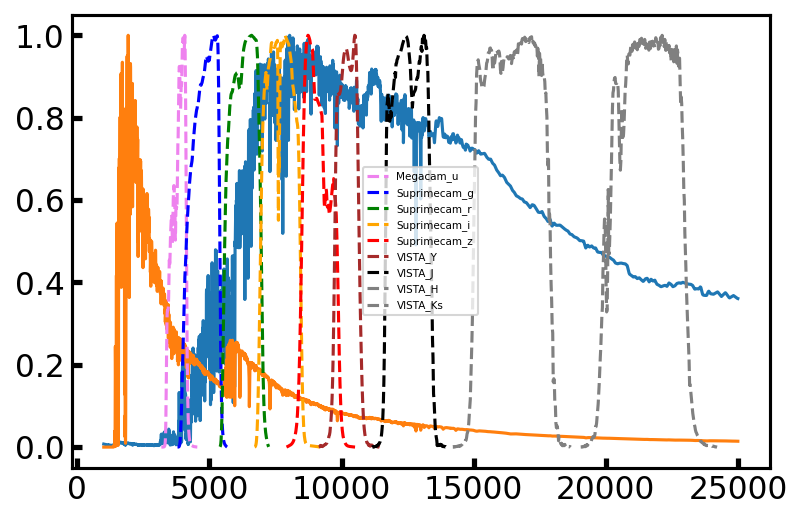

In [7]:
met, ext = 1, 0
old_lam, old_flux = broad_spec(5, 11.5, met, ext, 0.5)
new_lam, new_flux = broad_spec(0.1, 11.5, met, ext, 0.5)
plt.plot(old_lam,old_flux/max(old_flux))
plt.plot(new_lam,new_flux/max(new_flux))

filters = ['Megacam_u','Suprimecam_g','Suprimecam_r','Suprimecam_i','Suprimecam_z','VISTA_Y','VISTA_J','VISTA_H','VISTA_Ks']
colors  = ['violet','blue','green','orange','red','brown','black','grey','grey']
for i,filtname in enumerate(filters):
    filt = getfilter(filtname)
    plt.plot(filt['wave'],filt['transmission']/max(filt['transmission']),'--',color=colors[i],label=filtname)
plt.legend(fontsize=5)

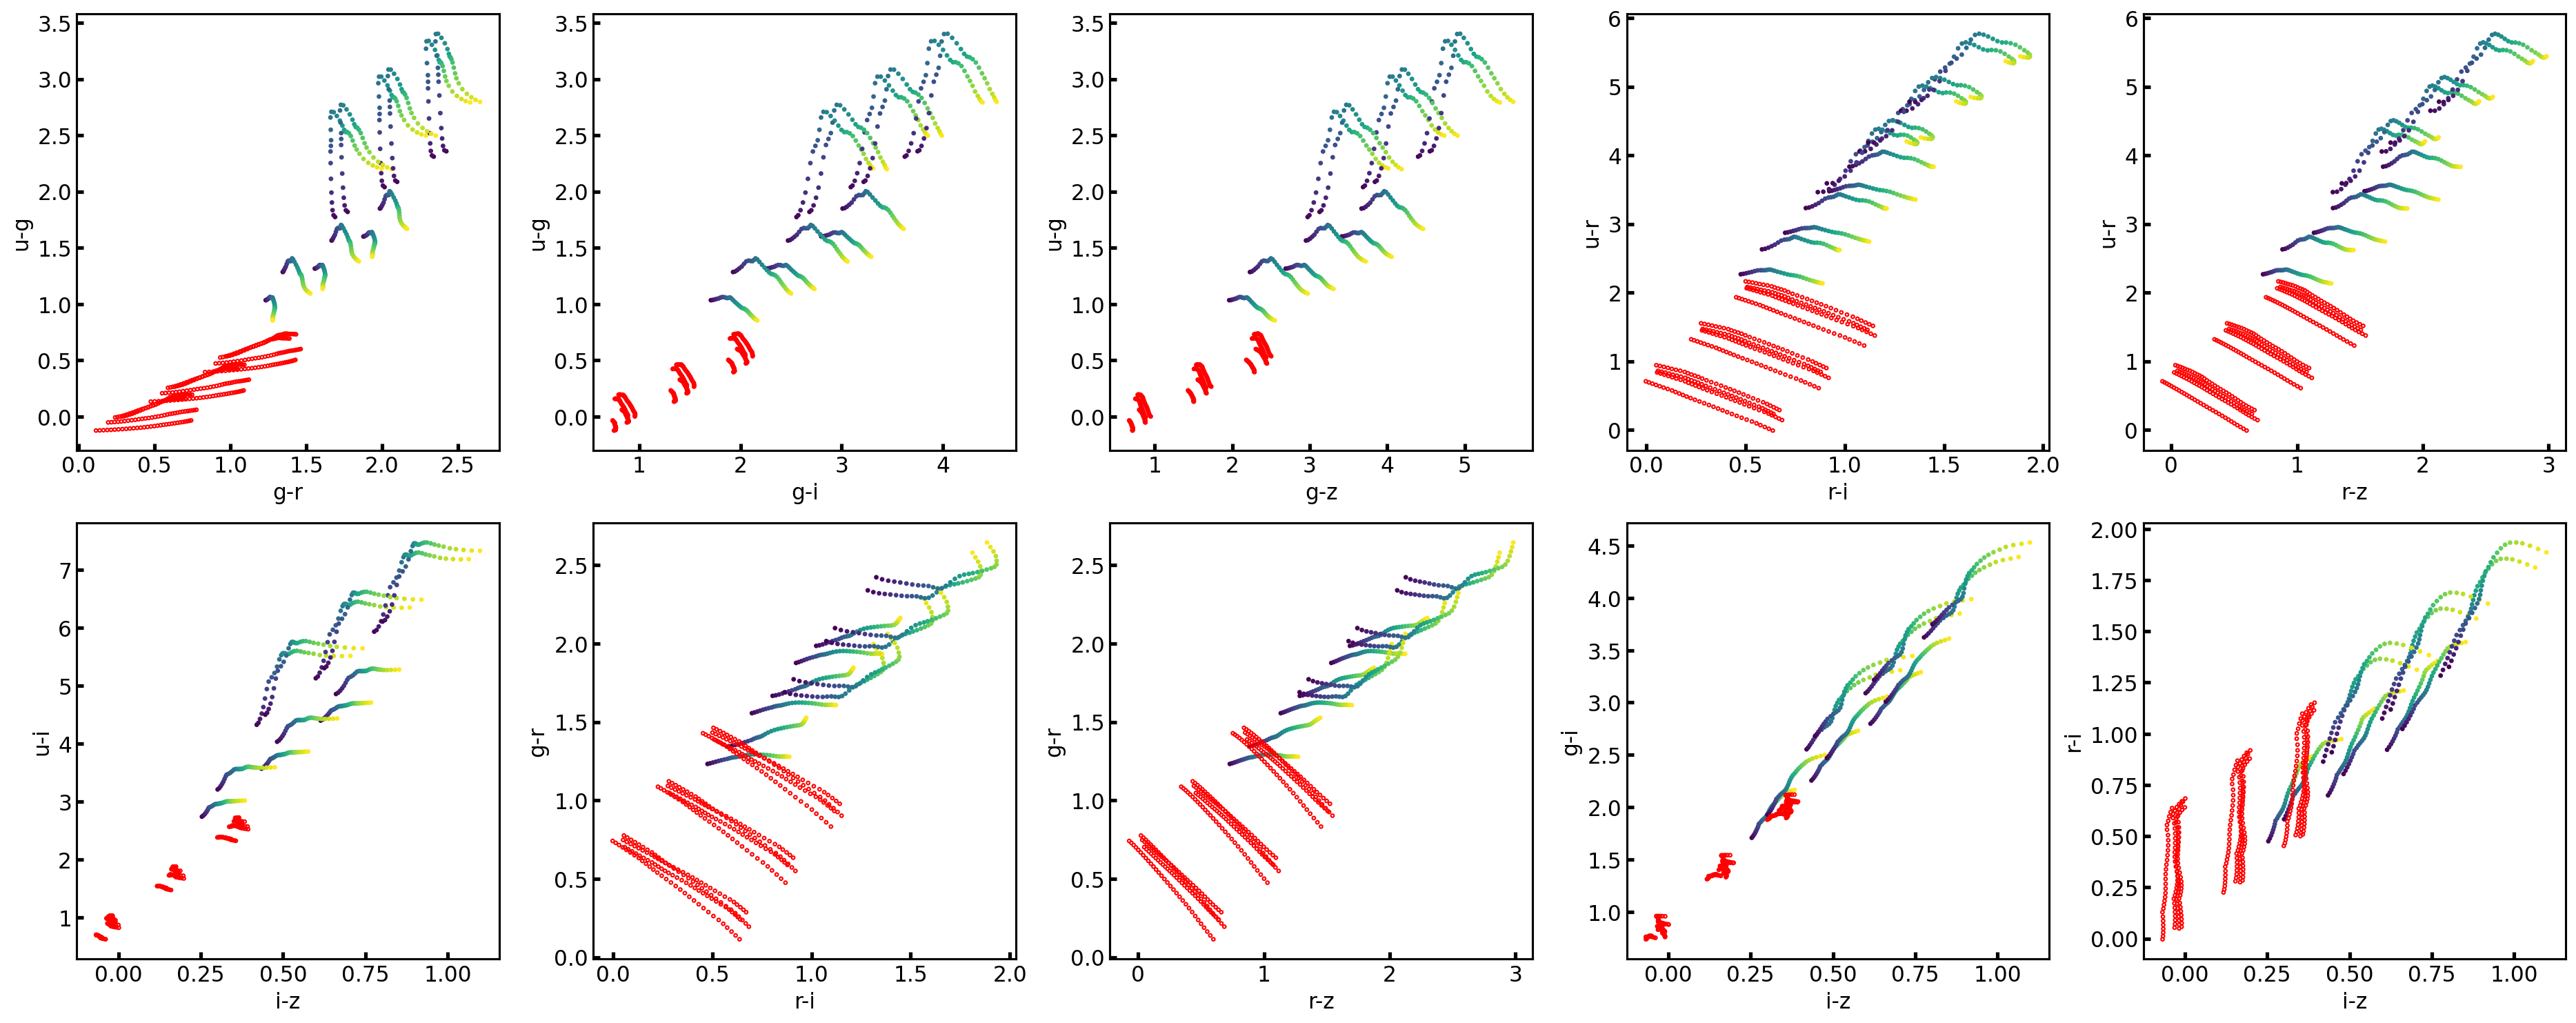

In [8]:
fig, axes = plt.subplots(nrows=2,ncols=5,figsize=[25,10])
for ifig, e in enumerate(it.combinations('ugriz', 3)):
    i, j = ifig//5, ifig%5
    ax = axes[i,j]
    for sample in old:
        mag = sample.data
        ax.scatter(mag[e[1]]-mag[e[2]],mag[e[0]]-mag[e[1]],c=zs,s=5)
    for sample in young:
        mag = sample.data
        ax.scatter(mag[e[1]]-mag[e[2]],mag[e[0]]-mag[e[1]],s=5, facecolors='none', edgecolors='r')       
    ax.set_ylabel(f'{e[0]}-{e[1]}')
    ax.set_xlabel(f'{e[1]}-{e[2]}')
plt.tight_layout()

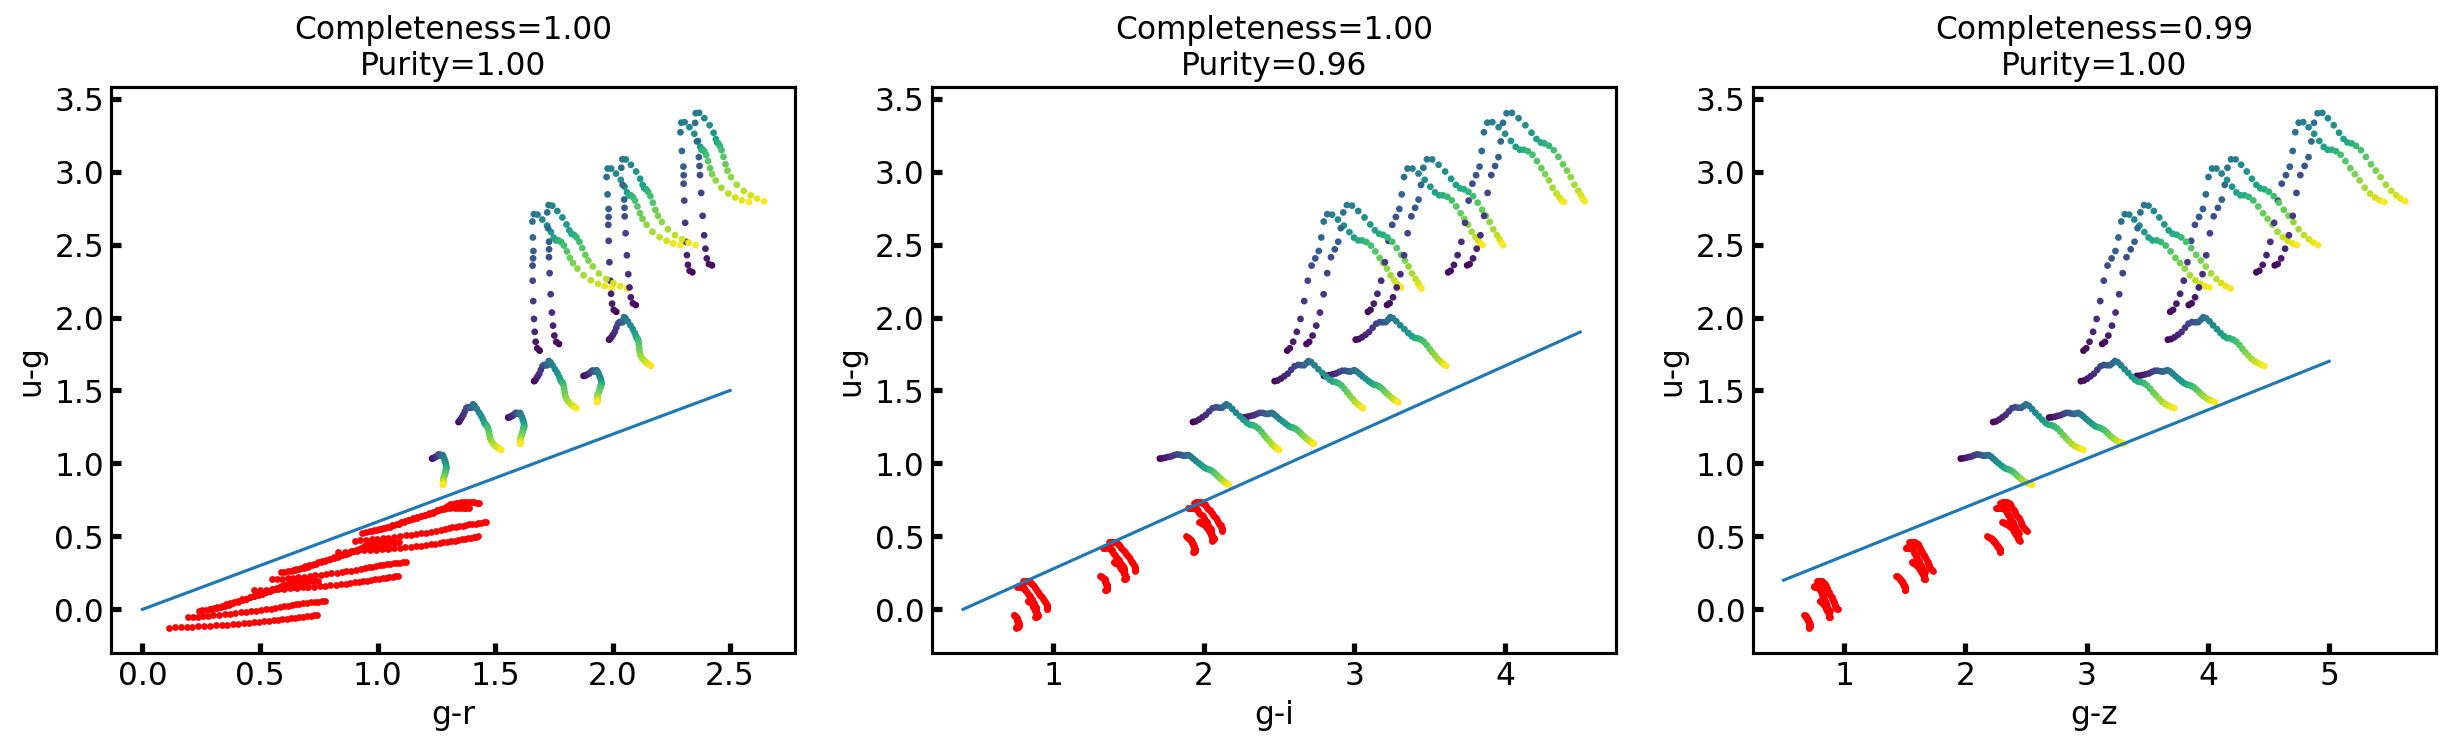

In [9]:
def select_color(cx,cy,px,py):
    selection = interp1d(px,py,fill_value='extrapolate')
    select_y = selection(cx)
    boolean = cy>select_y
    return np.sum(boolean)
colors = [['u','g','r'],['u','g','i'],['u','g','z']]
linex = [[0.0,2.5], [0.4,4.5], [0.5,5.0]]
liney = [[0.0,1.5], [0.0,1.9], [0.2,1.7]]

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,5))
for i in range(3):
    ax = axes[i]
    e = colors[i]
    TP, FP, TN, FN = 0, 0, 0, 0
    for sample in old:
        mag = sample.data
        cx, cy = mag[e[1]]-mag[e[2]], mag[e[0]]-mag[e[1]]
        lx, ly = linex[i], liney[i]
        ax.scatter(cx,cy,c=zs,s=5)
        TP += select_color(cx,cy,lx,ly)
        FN += len(cx)-select_color(cx,cy,lx,ly)
    for sample in young:
        mag = sample.data
        cx, cy = mag[e[1]]-mag[e[2]], mag[e[0]]-mag[e[1]]
        lx, ly = linex[i], liney[i]
        ax.scatter(cx,cy,c='red',s=5)
        FP += select_color(cx,cy,lx,ly)
        TN += len(cx)-select_color(cx,cy,lx,ly)
    
    ax.set_title(f'Completeness={TP/(TP+FN):.2f}\nPurity={TP/(TP+FP):.2f}')
    ax.plot(linex[i],liney[i])
    ax.set_ylabel(f'{e[0]}-{e[1]}')
    ax.set_xlabel(f'{e[1]}-{e[2]}')

#### D. If you want to have high completeness and purity in your survey, which color criteria would you propose?
I would propose the seperation in u-g-r color-color diagram. (u-g)>3/5*(g-r)
#### E. If you want to have high completeness levels for galaxies with stellar masses greater than 1e11 solar masses, to what limiting z-band magnitude will your survey need to be sensitive to?

In [10]:
all_z = []
all_i = []
for spec in old:
    all_z.append(max(spec.data['z']))
    all_i.append(max(spec.data['i']))
print(f'Consider all the extinction and metalliciy, the limiting z-band magnitude is {max(all_z):.2f}')
print(f'Consider all the extinction and metalliciy, the limiting i-band magnitude is {max(all_i):.2f}')

lam, flux = broad_spec(5,11,0.1,2, 0)

Consider all the extinction and metalliciy, the limiting z-band magnitude is 24.23
Consider all the extinction and metalliciy, the limiting i-band magnitude is 25.32


### Part III–Checking your survey design using the COSMOS+UVISTA catalog (5 points)
The goal of this section is to understand the process cosmologists and extragalactic observers use to test their proposed survey strategies using existing datasets. Apply your z-band magnitude limit and color selection criteria from Part II to the UVISTA+COSMOS catalog then estimate the following:
#### A. What fraction of galaxies more massive than 1e11 solar masses and with stellar populations older than 3 Gyr do you identify? This is the completeness expected of your spectroscopic sample.

In [11]:
nsa = Table.read('uvista_SmallProject3.fits')

In [12]:
u_g = nsa['m_u']-nsa['m_g']
g_r = nsa['m_g']-nsa['m_r']
z   = nsa['m_z']
boolean = (u_g>3/5*g_r)&(z<20)
nsa_ = nsa[boolean]

In [19]:
boolean = (nsa['log10(Mstar/Msun)']>11)&(10**nsa['log10(age/yr)']/1e9>3)
boolean_ = (nsa_['log10(Mstar/Msun)']>11)&(10**nsa_['log10(age/yr)']/1e9>3)

print(f'Completeness : {np.sum(boolean_)/np.sum(boolean):.2f}')

Completeness : 0.46


#### B. What fraction of your selected galaxies are actually the desired ones (>3 Gyr old stellar population, stellar mass > 1e11 solar masses) versus something else? This is the purity expected of your spectroscopic survey.

In [20]:
print(f'Purity : {np.sum(boolean_)/len(nsa_):.2f}')

Purity : 0.11


#### C. Is there anything you would change about your proposed selection criteria now that it has been tested with real data?
Since are selection criteria assumes a redshift range between 0.5-0.8, I apply the selection criteria on only this range of redshift. This additional criteria increase the completeness but lower the purity.

In [15]:
boolean = abs(nsa['z_peak_1']-0.65)<0.15
nsa_z = nsa[boolean]

u_g = nsa_z['m_u']-nsa_z['m_g']
g_r = nsa_z['m_g']-nsa_z['m_r']
z   = nsa_z['m_z']
boolean = (u_g>3/5*g_r)&(z<24.23)
nsa_z_ = nsa_z[boolean]


boolean = (nsa_z['log10(Mstar/Msun)']>11)&(10**nsa_z['log10(age/yr)']/1e9>3)
boolean_ = (nsa_z_['log10(Mstar/Msun)']>11)&(10**nsa_z_['log10(age/yr)']/1e9>3)

print(f'Completeness : {np.sum(boolean_)/np.sum(boolean):.2f}')
print(f'Purity : {np.sum(boolean_)/len(nsa_z_):.2f}')

Completeness : 0.90
Purity : 0.03


If not knowing the redshift of the sample, we should find another way to improve the selection. I first plot the color-color diagram of the NSA sample. It turns out that our color-color selection criteria can really pick out old galaxies.

Text(0, 0.5, 'u-g')

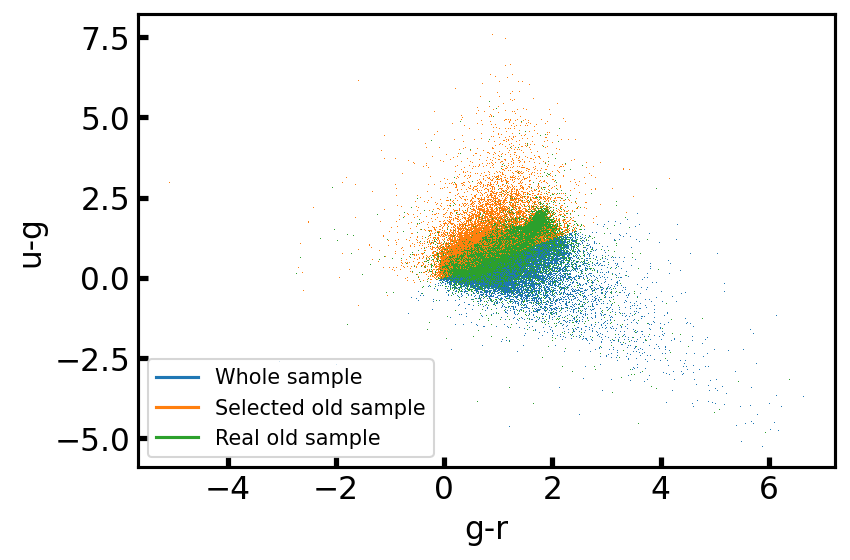

In [16]:
u_g = nsa['m_u']-nsa['m_g']
g_r = nsa['m_g']-nsa['m_r']
bool1 = (u_g>3/5*g_r)
bool2 = 10**nsa['log10(age/yr)']/1e9>3
plt.plot(g_r,u_g,',')
plt.plot(g_r[bool1],u_g[bool1],',')
plt.plot(g_r[bool2],u_g[bool2],',')
plt.plot([],[],color='tab:blue',label='Whole sample')
plt.plot([],[],color='tab:orange',label='Selected old sample')
plt.plot([],[],color='tab:green',label='Real old sample')
plt.legend(fontsize=10)
plt.xlabel('g-r')
plt.ylabel('u-g')

However, this is not the case for the z-limit selection criteria. In this selection, we claim all galaxies that have z-band magnitude less than 24.2 (points at the left side of green dash line) are all massive galaxies. However, it's obvious that only a small fraction of them are really larger than $10^{11} M_\odot$. I think this is the main reason that we cannot get a good purity. 

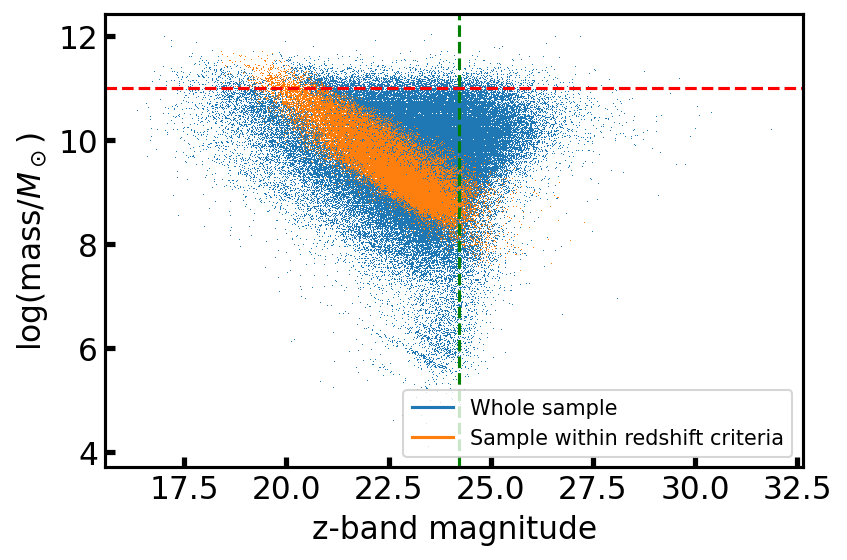

In [17]:
z = nsa_['m_z']
boolean = abs(nsa['z_peak_1']-0.65)<0.15
plt.plot(nsa['m_z'],nsa['log10(Mstar/Msun)'],',')
plt.plot(nsa['m_z'][boolean],nsa['log10(Mstar/Msun)'][boolean],',')
plt.axhline(11,ls='--',color='red')
plt.axvline(24.23,ls='--',color='green')
plt.plot([],[],color='tab:blue',label='Whole sample')
plt.plot([],[],color='tab:orange',label='Sample within redshift criteria')
plt.legend(fontsize=10)
plt.xlabel('z-band magnitude')
plt.ylabel('log(mass/$M_\odot$)')
plt.show()